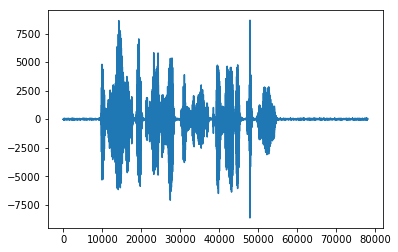

sig: -8660.0 - 8668.0


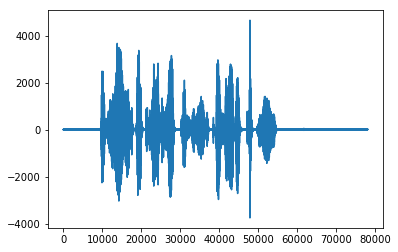

sig_h1: -3761.3767483416686 - 4654.264114014278


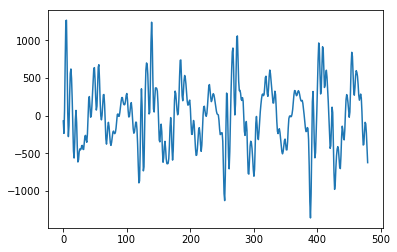

frame1: -1356.4949163755775 - 1268.7008963653468
r_prime: (21,)
r, r_prime: [ 37636304.9003464   34351083.70135434  26647784.57506742
  19175845.82459872  15477774.13046711  15839104.04088242
  17938904.83339121  19002864.53892365  17350470.71659363
  12645694.47345366   5662127.95336201  -1839007.91609825
  -7595449.50751282 -10160034.26934304 -10203838.29820965
 -10253662.69061209 -12635612.13068177 -17412966.68276904
 -22352870.53141018 -24974049.27793273 -24628848.6116725 ] [ 37640068.53083643  34341549.76070016  26618213.14729334
  19127999.68077037  15409184.77845642  15729568.04512804
  17760534.52491774  18746145.99665613  17044956.41858861
  12364538.86716726   5507118.47001504  -1778266.03645657
  -7297832.75452887  -9694418.92817904  -9663517.9504258   -9632847.63892009
 -11768871.47507501 -16070636.10046374 -20430277.22243164
 -22592769.68560777 -22040582.52155326]
lp coeffs (lecture): [ 1.         -2.56242472  3.02469638 -1.83485399  0.41458073 -0.05076194
  0.06390305  0.

(array([ 37640068.53083643,  34341549.76070016,  26618213.14729334,
         19127999.68077037,  15409184.77845642,  15729568.04512804,
         17760534.52491774,  18746145.99665613,  17044956.41858861,
         12364538.86716726,   5507118.47001504,  -1778266.03645657,
         -7297832.75452887,  -9694418.92817904,  -9663517.9504258 ,
         -9632847.63892009, -11768871.47507501, -16070636.10046374,
        -20430277.22243164, -22592769.68560777, -22040582.52155326,
        -20123021.81298394, -18666255.56336002, -18558881.97841987,
        -19423292.60192903]),
 array([ 1.        , -2.56646139,  2.99925028, -1.77486344,  0.3556465 ,
        -0.02809895,  0.05709942,  0.09316706, -0.23013077, -0.01925869,
         0.12121028,  0.0867447 ,  0.04819505, -0.23430808,  0.11278921,
         0.15125304, -0.09676035,  0.09129183, -0.23390329,  0.13030941,
         0.24879379, -0.49471996,  0.29374797, -0.02100115, -0.02482906]),
 48.944091680952802,
 array([[ 121.43671623]]),
 0.13750000

In [47]:
import os
import numpy as np
import scipy
from scipy.signal import blackmanharris, fftconvolve, deconvolve
from levinson import LEVINSON, rlevinson
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
"""
This is an implementation of the G729 Voice Activity Decoder algorithm.  The
parameters are the full-band energy, the low-band energy, the zero-crossing rate
and a spectral measure.

# https://www.itu.int/rec/T-REC-G.729-201206-I/en
# https://www.itu.int/rec/dologin_pub.asp?lang=e&id=T-REC-G.729-201206-I!!SOFT-ZST-E&type=items

'Short-term prediction or linear prediction analysis is performed once per speech
frame using the autocorrelation method with a 30 ms asymmetric window. Every 80
samples (10 ms), the autocorrelation coefficients of windowed speech are
computed and converted to the LP coefficients using the Levinson-Durbin
algorithm. Then the LP coefficients are transformed to the LSP domain for
quantization and interpolation purposes.'

# https://en.wikipedia.org/wiki/Levinson_recursion



"""
class G729VAD(object):
    def __init__(self, fs_ms=10, ws_ms=30, k = 10, sr = 16000):
        self.fs = int(fs_ms * (sr / 1000))
        self.ws = int(ws_ms * (sr / 1000))
        self.k = k
        self.sr = sr
        self.N_i = 32
        
    def H_h1(self, z):
        """
        param z: raw 16-bit PCM signal.  Using z because original paper does so
        return: preprocessed signal with scaling and high-pass filter
        """
        x = np.zeros(z.shape[0])
        y = np.zeros(z.shape[0])
        for i, z_i in enumerate(z):
            x_n1 = 0. if i < 1 else z[i-1]
            x_n2 = 0. if i < 2 else z[i-2]
            y_n1 = 0. if i < 1 else y[i-1]
            y_n2 = 0. if i < 2 else y[i-2]
            y[i] = (0.46363718*z_i-0.92724705*x_n1+0.46363718*x_n2)-(-1.9059465*y_n1 + 0.9114024*y_n2)
        return(y)

    def w_lp(self):
        """
        windowing function as specified in the paper
        5/6's a half Hamming with a last 1/6th as the downslope of a cosine.
        kinda looks like a gaussian skewed to the right
        """
        fs = self.fs
        ws = self.ws
        M = int(ws * (5/6))
        f1 = scipy.signal.hamming(M*2)[:M]
        f2 = np.cos(2. * np.pi * (np.arange(M,ws)-M) / ((ws-M)*4 - 1))
        return(np.r_[f1,f2])

    def autocorr_coefs(self, s, k=None, bnd_exp=60):
        """
        r(k) = summation(n=k to ws-1)*s_prime(n)*s_prime(n - k), k=0, ..., 10
        """
        
        k = k if k is not None else self.k
        win = self.w_lp()
        s_prime = win * s
        # r[0], r[1, ..., k]
        r_0 = np.sum(s_prime*s_prime)
        r_0 = np.clip(r_0, 1., None)
        r_1_k = np.array([np.sum(s_prime[k_i:]*s_prime[:-k_i]) for k_i in range(1, k+1)])
        r = np.r_[r_0, r_1_k]
        #r /= r[0]

        w_lag = np.exp(-.5*(2.*np.pi*bnd_exp*(np.arange(1, k+1))/self.sr)**2)
        r_prime_0 = np.array([r[0]*1.0001])
        r_prime_1_k = w_lag * r[1:]
        r_prime = np.r_[r_prime_0, r_prime_1_k]
        return(r, r_prime)

    def lp_filter_coefs_gsm(self, r_prime):
        """
        Taking this directly from the lpc.c file
        """
        a = np.zeros(self.k+1)
        
        a[0] = 1.
        acc = -r_prime[1]/r_prime[0]
        a[1] = acc.copy()
        alpha = r_prime[0] * (1.-acc**2)
        an = a.copy()
        for i in range(2, self.k+1):    
            acc = r_prime[i]
            j_iter = range(1, i)
            for j in j_iter:
                acc -= a[i-j]*r_prime[j]
            acc /= alpha

            for j in j_iter:
                an[j] = a[j] + acc*a[i-j]
            an[i] = acc
            
            alpha = alpha * (1.-acc**2)
            a = an.copy()
        return(a)

    def lp_filter_coefs_pdf(self, R):
        E = np.zeros(self.k+1)
        k = np.zeros(self.k+1)
        a = np.zeros((self.k+1, self.k+1))
        E[0] = R[0]
        a[0, self.k] = 1.
        
        for i in range(1, self.k+1):
            acc = R[i]
            j_iter = range(1, i)
            for j in j_iter:
                acc -= a[j, i-1]*R[i-j]
            acc /= E[i-1]

            a[i, i] = acc.copy()

            for j in j_iter:
                a[j, i] = a[j, i-1] - acc*a[i-j, i-1]
            E[i] = (1.-acc**2)*E[i-1]
        a[1:, :] = -a[1:, :]
        return(a[:,self.k])
    
    def lp_filter_coefs_matrix(self, r_prime):
        r_prime_len = r_prime.shape[0]-1
        R = np.zeros((r_prime_len, r_prime_len))
        for i in range(1, r_prime_len+1):
            for j in range(1, r_prime_len+1):
                R[i-1, j-1] = r_prime[np.abs(j-i)]
        a = np.linalg.inv(R).dot(-r_prime[1:])
        a = np.r_[1., a]
        return a

    def lp_to_lsp(self, z, lp_coeffs):
        # temp vars
        A_z = self._A(z, lp_coeffs)
        z_n11 = self._z_ni(z, self.k+1)
        z_n1 = self._z_ni(z, 1)
        A_z_n1 = self._A(z_n1, lp_coeffs)
        # F1_prime and F2_prime
        F1_prime = A_z + z_n11 * A_z_n1
        F2_prime = A_z - z_n11 * A_z_n1
        # F1 and F2
        F1 = F1_prime / (1. + z_n1)
        F2 = F2_prime / (1. - z_n1)
        
        unit_cir_span = np.linspace(0, np.pi, 62)        
        z_n2 = self._z_ni(z, 1)
        F1_check = 1. - np.cos(unit_cir_span[1:-1])[:,None]*z_n1 + z_n2
        
        f1 = np.zeros(self.k//2 + 1)
        f2 = np.zeros(self.k//2 + 1)
        f1[0] = 1.
        f2[0] = 1.
        for i in range(int(self.k//2)):
            f1[i+1] = lp_coeffs[i+1]+lp_coeffs[self.k-i]-f1[i]
            f2[i+1] = lp_coeffs[i+1]-lp_coeffs[self.k-i]+f2[i]
        print(f1, f2)
        
        return(F1, F2)
    
    def W(self, z, coeffs, gamma = 0.75):
        return(self._A(z, coeffs) / self._A(z / gamma, coeffs))
    
    

    def _A(self, z, coeffs):
        S = np.zeros(z.shape[0])
        for i in range(z.shape[0]):
            i_st = 0 if i < self.k else i - (self.k-1)
            i_end = i - i_st + 1
            z_cut = z[i_st:][:i_end] if i_end > self.k else np.r_[np.zeros(self.k-i_end), z[i_st:][:i_end]]
            S[i] = 1 + (coeffs[1:]*z_cut).sum()
        return(S)
    
    def _z_ni(self, z, i):
        return(np.r_[np.zeros(i), z[:-i]])
    
    def poly2lsf(self, a):
        """Prediction polynomial to line spectral frequencies.

        converts the prediction polynomial specified by A,
        into the corresponding line spectral frequencies, LSF. 
        normalizes the prediction polynomial by A(1).

        .. doctest::

            >>> a = [1.0000  ,  0.6149   , 0.9899   , 0.0000 ,   0.0031,   -0.0082
            >>> lsf = poly2lsf(a)
            >>> lsf =  array([  0.7842,    1.5605 ,   1.8776 ,   1.8984,    2.3593])

        .. seealso:: lsf2poly, poly2rc, poly2qc, rc2is
        http://janroman.dhis.org/AFI/Python/spectrum/src/spectrum/linear_prediction.py
        """

        #Line spectral frequencies are not defined for complex polynomials.

        # Normalize the polynomial

        a = np.array(a)
        if a[0] != 1:
            a/=a[0]

        if np.abs(np.roots(a)).max() >= 1.0:
            print(np.abs(np.roots(a)))
            print('The polynomial must have all roots inside of the unit circle.');


        # Form the sum and differnce filters

        p  = len(a)-1   # The leading one in the polynomial is not used
        a1 = np.concatenate((a, np.array([0])))        
        a2 = a1[-1::-1]
        P1 = a1 - a2        # Difference filter
        Q1 = a1 + a2        # Sum Filter 

        # If order is even, remove the known root at z = 1 for P1 and z = -1 for Q1
        # If odd, remove both the roots from P1

        if p%2: # Odd order
            P, r = deconvolve(P1,[1, 0 ,-1])
            Q = Q1
        else: # Even order 
            P, r = deconvolve(P1, [1, -1])
            Q, r = deconvolve(Q1, [1,  1])

        rP  = np.roots(P)
        rQ  = np.roots(Q)

        aP  = np.angle(rP[1::2])
        aQ  = np.angle(rQ[1::2])

        lsf = np.sort(np.concatenate((-aP,-aQ)))
        
        return lsf
    
    def ac2poly(self, data):
        """Convert autocorrelation sequence to prediction polynomial

        :param array data:    input data (list or numpy.array)
        :return: 
            * AR parameters
            * noise variance

        This is an alias to::

            a, e, c = LEVINSON(data)

        :Example:

        .. doctest::

            >>> r = [5, -2, 1]
            >>> ar, e = ac2poly(r)
            >>> ar
            array([ 1. ,  0. , -0.2])
            >>> e
            4.7999999999999998

        """
        a, e, _c = LEVINSON(data, allow_singularity=False)
        a = np.insert(a, 0, 1) 
        return a, e
    
    def vad(self, s, lp_coeffs, r_prime, i):
        R = r_prime[:(self.k+4)]
        E_full = 10.*np.log10(R[0]/self.ws)
        h = self._A(s, lp_coeffs)[:R.shape[0]].reshape(-1, 1) # h as column vector
        R_toeplitz = scipy.linalg.toeplitz(R)
        E_low = 10.*np.log10(h.T.dot(R_toeplitz).dot(h))
        ZC = np.abs(np.sign(s[:self.fs])-np.sign(s[1:(self.fs+1)])).sum()/(self.fs*2)
        if i < self.N_i:
            # don't use running averages yet
            pass
        else:
            # use averages
            pass
    
files = librosa.util.find_files("pcsnpny-20150204-mkj/wav")
fp = files[0]
#sig, sr = librosa.core.load(fp, sr=None)
sr, sig = scipy.io.wavfile.read(fp)
sig = sig.astype(np.float)
plt.plot(sig)
plt.show()
print("sig: {} - {}".format(sig.min(), sig.max()))

vad = G729VAD(k=20)
sig_h1 = vad.H_h1(sig)
plt.plot(sig_h1)
plt.show()
print("sig_h1: {} - {}".format(sig_h1.min(), sig_h1.max()))
frame1 = sig_h1[12000:12480]
plt.plot(frame1)
plt.show()
print("frame1: {} - {}".format(frame1.min(), frame1.max()))
r, r_prime = vad.autocorr_coefs(frame1)
print("r_prime:", r_prime.shape)
print("r, r_prime:", r, r_prime)
lp_coeffs_pdf = vad.lp_filter_coefs_pdf(r_prime)
lp_coeffs_matrix = vad.lp_filter_coefs_matrix(r_prime)
print("lp coeffs (lecture):", lp_coeffs_pdf)
print("lp coeffs (matrix):", lp_coeffs_matrix)
lp_coeffs_internet = vad.ac2poly(r_prime)[0]
print("lp coeffs (internet):", lp_coeffs_internet)
lsp_coeffs_matrix = vad.poly2lsf(lp_coeffs_matrix)
print("lsp coeffs (matrix):", lsp_coeffs_matrix)
lsp_coeffs_matrix_quantized = np.arccos(np.polynomial.chebyshev.Chebyshev(lsp_coeffs_matrix).roots())
print("lsp coeffs quantized(matrix):", lsp_coeffs_matrix_quantized, lsp_coeffs_matrix_quantized.shape)


r, r_prime = vad.autocorr_coefs(frame1, k = vad.k+4)
R = r_prime
LSF = vad.lp_filter_coefs_matrix(r_prime)
E_full = 10*np.log10(R[0]/vad.ws)
print(int(r_prime.shape[0]//2+1))
R_toeplitz = scipy.linalg.toeplitz(R[:int(r_prime.shape[0]//2+1)], np.r_[R[0], R[int(r_prime.shape[0]//2+1):]])
h = vad._A(frame1, lp_coeffs_matrix)[:R_toeplitz.shape[0]].reshape(-1, 1)
print(R.shape, h.shape, R_toeplitz.shape)
E_low = 10*np.log10(h.T.dot(R_toeplitz).dot(h))
ZC = np.abs(np.sign(frame1[:vad.fs])-np.sign(frame1[1:(vad.fs+1)])).sum()/(vad.fs*2)
R, LSF, E_full, E_low, ZC

In [62]:
a1 = np.concatenate((lp_coeffs_matrix, np.array([0])))
a2 = a1[::-1]

P1 = a1 - a2        # Difference filter
Q1 = a1 + a2        # Sum Filter 

print(len(lp_coeffs_matrix)-1)
P, _ = deconvolve(P1,[1, -1])
Q, _ = deconvolve(Q1, [1, 1])
rP = np.roots(P)
rQ = np.roots(Q)
aP = np.angle(rP[1::2])
aQ = np.angle(rQ[1::2])

lsf = np.sort(np.concatenate((-aP,-aQ)))

2*np.exp(-1j*5*lsf)
roots = np.polynomial.chebyshev.Chebyshev(lsf).roots()
np.arccos(roots)
scipy.signal.hamming(vad.fs)[:24]
scipy.linalg.toeplitz(R).shape
gamma = 0.75
W_z = A_z / A_z*gamma

20


(21, 21)

In [ ]:
def autocorr_all_frames(s):
    """
    param sig: numpy array of a raw or preprocessed audio signals
    param fs: size of each frame (160 = 10ms @ 16,000hz)

    return: list of autocorrelations for each frame
    """
    fs = self.fs
    num_frames = int(s.shape[0] // fs)
    Corrs = []
    for i in range(num_frames):
        st = int(i * fs)
        end = int(st + fs)
        c = fftconvolve(s[st:end], s[st:end][::-1], mode="full")
        c = c[len(c)//2:]
        Corrs.append(c)
    return(Corrs)


zero_crossing_rate(sig[400:480])

freqs = np.fft.rfft(sig[:320])
auto1 = freqs * np.conj(freqs)


np.corrcoef(corr)
np.corrcoef(autocorrelation(corr))
corr2 = autocorrelation(corr)
plt.plot(corr2)
corr3 = autocorrelation(corr2)
plt.plot(corr3)
np.corrcoef(corr3)

corr4 = autocorrelation(corr3)
plt.plot(corr4)
np.corrcoef(corr4)


"""

frame = 160 # in the paper this is 80, but the sampling rate is 8000Hz not 16000
def autocorrelation(x):
    c = fftconvolve(x, x[::-1], mode="full")
    c = c[len(c)//2:]
    return(c)

autocorrs = []
for i in range(int(sig.shape[0] // hs)):
    st = int(i * hs)
    end = int(st + hs)
    x = sig[st:end]
    autocorrs += [autocorrelation(x)]
len(autocorrs)
np.corrcoef(autocorrs[:12])[0, :]

# set of parameters extracted for each frame q = 12
# a set of autocorrelation coefficients
R = np.zeros(12)

# Line spectral frequencies (LSF), a set of linear prediction coefficients
# derived from the autocorrelation p = 10
LSF = np.zeros(10)

# full-band energy: log of the normalized first autocorrelation coeff
def full_band_energy(R, N=240):
    return(10 * np.log10((1. / N) * R[0]))
E_f = full_band_energy(R)

# low-band energy: measured on 0 to F_l Hz band
# h is the impulse response of an FIR filter with a cut-off freq of F_l Hz
# R is the Toeplitz autocorrelation matrix
def low_band_energy(R, h, N=240):
    return(10 * np.log10((1. / N) * h.T.dot(R).dot(h)))
E_l = low_band_energy(R, h)

def zero_crossing_rate(sig, M=80):
    x = sig[:M]
    return(np.sum(np.abs(np.sign(x[:-1])-np.sign(x[1:])))/(2*M))
"""

In [36]:
R, scipy.linalg.toeplitz(R[:11], np.r_[R[0], R[11:]]).shape

(array([ 37640068.53083643,  34341549.76070016,  26618213.14729334,
         19127999.68077037,  15409184.77845642,  15729568.04512804,
         17760534.52491774,  18746145.99665613,  17044956.41858861,
         12364538.86716726,   5507118.47001504,  -1778266.03645657,
         -7297832.75452887,  -9694418.92817904,  -9663517.9504258 ,
         -9632847.63892009, -11768871.47507501, -16070636.10046374,
        -20430277.22243164, -22592769.68560777, -22040582.52155326]), (11, 11))